<font color = 'red'> Task 1: </font> There are 7 jurors in the courtroom. Each of them individually can correctly determine whether the defendant is guilty or not with 80% probability. How likely is the jury will make a correct verdict jointly if the decision is made by majority voting?

In [1]:
print(round((35*(0.8**4)*(.2**3)+21*(0.8**5)*(.2**2)+7*(0.8**6)*(.2**1)+1*(0.8**7)*1)*100, 2), '%')

96.67 %


<font color = 'red'> Answer(1): </font> 96.66%

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



Let us implement a function that will replace the NaN values by the median in each column of the table.


In [2]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table  



Reading the data:


In [3]:
data = pd.read_csv('../data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


View data types of the features:

In [4]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object



Look at the distribution of classes in target:


Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

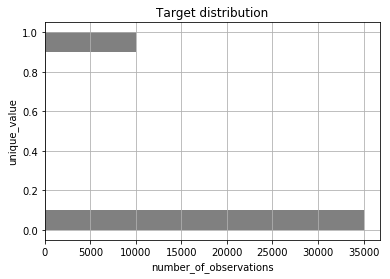

In [5]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='gray')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

Select all the features and drop the target:

In [6]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

We apply a function that replaces all values of NaN by the median value of the corresponding column.

In [7]:
table = impute_nan_with_median(data)



Split the target and features - now we get a training sample.


In [8]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

# Bootstrap

<font color = 'red'> Task 2. </font> Make an interval estimate based on the bootstrap of the average income (MonthlyIncome) of customers who had overdue loan payments, and of those who paid in time, make 90% confidence interval. Find the difference between the lower limit of the derived interval for those who paid in time and the upper limit for those who are overdue. So, you are asked to build 90% intervals for the income of "good" customers [good_income_lower,good_income_upper] and for "bad" - [bad_income_lower,bad_income_upper] and find the difference good_income_lower−bad_income_upper.

In [10]:
table['bad_guys'] = ((table['NumberOfTime30-59DaysPastDueNotWorse'] >0)|\
      (table['NumberOfTime60-89DaysPastDueNotWorse'] >0)|\
      (table['NumberOfTimes90DaysLate'] >0)).astype('int')

In [15]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

np.random.seed(17)

good_guys = table[table['SeriousDlqin2yrs']==0]['MonthlyIncome'].values
bad_guys = table[table['SeriousDlqin2yrs']==1]['MonthlyIncome'].values

bad = np.mean(get_bootstrap_samples(bad_guys, 1000), axis=1)
good = np.mean(get_bootstrap_samples(good_guys, 1000), axis=1)

print('Интервальная оценка зарплаты хороших клиентов = ', stat_intervals(good, 0.1))
print('Интервальная оценка зарплаты плохих клиентов = ', stat_intervals(bad, 0.1))
print(round(stat_intervals(good, 0.1)[0] - stat_intervals(bad, 0.1)[1]))
#good_income_lower−bad_income_upper.

Интервальная оценка зарплаты хороших клиентов =  [6294.02952878 6517.48153952]
Интервальная оценка зарплаты плохих клиентов =  [5462.17301516 5641.20421404]
653.0


<font color = 'red'> Answer(2): </font> 654

# Decision tree, hyperparameter tuning

One of the main performance metrics of a model is the area under the ROC curve. The ROC-AUC values lay between 0 and 1. The closer the value of ROC-AUC to 1, the better the classification is done.

Find the values of DecisionTreeClassifier hyperparameters using theGridSearchCV, which maximize the area under the ROC curve.

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Use the DecisionTreeClassifier class to create a decision tree. Due to the imbalance of the classes in the target, we add the balancing parameter. We also use the parameter random_state = 17 for the reproducibility of the results.

In [17]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

We will look through such values of hyperparameters:

In [18]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

Fix cross-validation parameters: stratified, 5 partitions with shuffle, random_state

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)


<font color = 'red'> Task 3. </font>  Run GridSearch with the ROC AUC metric using the hyperparameters from the tree_params dictionary. What is the maximum ROC AUC value (round up to 2 decimals)? We call cross-validation stable if the standard deviation of the metric on the cross-validation is less than 1%. Was cross-validation stable under optimal combinations of hyperparameters (i.e., providing a maximum of the mean ROC AUC value for cross-validation)?

In [20]:
gcv = GridSearchCV(dt, tree_params, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc');

In [21]:
gcv.fit(X, y);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


In [70]:
#y_pred = gcv.predict_proba(X)[:,1]??????????????????????????????
#print('roc_auc_score: ',roc_auc_score(y, y_pred))?????????????????????
#0.8354??????????????????????????????????

In [22]:
gcv.best_score_

0.8203023476209635

In [23]:
gcv.best_params_

{'max_depth': 7, 'max_features': 6}

In [24]:
gcv.cv_results_['mean_test_score'].argmax()

10

In [25]:
a = gcv.cv_results_['mean_test_score'][10]
a

0.8203023476209635

In [26]:
b = gcv.cv_results_["std_test_score"][10]
b

0.002758483553592935

In [31]:
print(100*(b/a),'%')

0.3362764426547204 %


In [28]:
gcv.cv_results_['mean_test_score']

array([0.81089154, 0.8043939 , 0.81111502, 0.81487177, 0.81574356,
       0.81615275, 0.8146449 , 0.81903996, 0.81754694, 0.81685585,
       0.82030235, 0.81903131, 0.81448767, 0.81661305, 0.8148858 ,
       0.8163828 , 0.80887829, 0.81197468, 0.80964848, 0.80987945])

In [29]:
gcv.cv_results_["std_test_score"]

array([0.00332252, 0.00196126, 0.00241302, 0.00196384, 0.00277056,
       0.0029564 , 0.00298129, 0.00119434, 0.00271735, 0.00443893,
       0.00275848, 0.00201456, 0.00127816, 0.00294106, 0.00240157,
       0.00363321, 0.00484198, 0.00280234, 0.00378275, 0.00317558])

<font color = 'red'> Answer(3): </font> 0.82, yes

# Simple RandomForest implementation

<font color = 'red'> Task 4. </font>  Implement your own random forest using DecisionTreeClassifier with the best parameters from the previous task. There will be 10 trees, the predicted probabilities of which you need to average.

Perform cross-validation. What is the average ROC AUC for cross-validation? Select the closest value.

In [42]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class RandomForestClassifierCustom(BaseEstimator):
    
    def __init__(self, n_estimators=10, max_depth=7, max_features=6, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        
        self.trees = []
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
        for i in range(self.n_estimators):            
            np.random.seed(self.random_state + i)            
            fibt_temp = np.random.choice(X.columns, self.max_features, replace=False) 
            IDs = np.random.choice(len(X), len(X), replace=True)
            sam = X.iloc[IDs]
            sample = sam[fibt_temp]
            y_sample = y.iloc[IDs]

            tree = DecisionTreeClassifier(max_depth=self.max_depth,\
                                          max_features=self.max_features,\
                                          random_state=self.random_state ,\
                                          class_weight='balanced')
            tree.fit(sample, y_sample)            
            self.trees.append(tree)
            self.feat_ids_by_tree.append(fibt_temp)

        return self
       
    def predict_proba(self, X):
        
        predict = []       
        for i in range(self.n_estimators):
            predict.append(self.trees[i].predict_proba(X[self.feat_ids_by_tree[i]]))          
        return np.mean(predict, axis=0)

In [43]:
gcv.best_params_

{'max_depth': 7, 'max_features': 6}

In [44]:
# МОЙ СОБСТВЕННЫЙ КЛАСС
rfccece = RandomForestClassifierCustom(n_estimators=10, max_depth=7, max_features=6, random_state=17)
rfccece.fit(X, y)
rfccece.predict_proba(X)

array([[0.83304158, 0.16695842],
       [0.78564994, 0.21435006],
       [0.64155134, 0.35844866],
       ...,
       [0.55937753, 0.44062247],
       [0.4023296 , 0.5976704 ],
       [0.21051129, 0.78948871]])

In [45]:
skf2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cross_val_score(rfccece,X , y, scoring='roc_auc', cv=skf2).mean()

0.8313033756157321

<font color = 'red'> Answer(4): </font> 0.833

<font color = 'red'> Task 5. </font> Let us compare our own implementation of a random forest with sklearn version of it. To do this, use RandomForestClassifier (class_weight='balanced', random_state = 17), specify all the same values for max_depth and max_features as before. What average value of ROC AUC on cross-validation we finally got? Select the closest value.

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_depth=7, class_weight='balanced', max_features=6, random_state=17)
rf.fit(X, y)
rf.predict_proba(X)

array([[0.85628528, 0.14371472],
       [0.8239271 , 0.1760729 ],
       [0.65271997, 0.34728003],
       ...,
       [0.60556855, 0.39443145],
       [0.42818127, 0.57181873],
       [0.20186207, 0.79813793]])

In [47]:
skf3 = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
cross_val_score(rf, X, y, scoring='roc_auc', cv=skf3).mean()

0.8300198245309829

<font color = 'red'> Answer(5): </font> 0.833

# sklearn RandomForest, hyperparameter tuning

<font color = 'red'> Task 6. </font> In the third task, we found the optimal hyperparameters for one tree. However it could be that these parameters are not optimal for an ensemble. Let's check this assumption with GridSearchCV (RandomForestClassifier (class_weight='balanced', random_state = 17) ). Now we extend the value of max_depth up to 15, because the trees need to be deeper in the forest (you should be aware of it from the article). What are the best values of hyperparameters now?

In [50]:
max_depth_values = range(5, 15)
max_features_values = [4, 5, 6, 7]
forest_params = {'max_depth': max_depth_values,
                'max_features': max_features_values}

In [51]:
rfc = RandomForestClassifier(class_weight='balanced', random_state = 17)
skf4 = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
gcv4 = GridSearchCV(rfc, forest_params, n_jobs=-1, cv=skf4, verbose=1, scoring='roc_auc');
gcv4.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   50.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(5, 15), 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [52]:
gcv4.best_params_

{'max_depth': 8, 'max_features': 4}

<font color = 'red'> Answer(6): </font> max_depth=8, max_features=4

# Logistic regression, hyperparameter tuning

<font color = 'red'> Task 7. </font>  Now let's compare our results with logistic regression (we indicate class_weight = 'balanced' and random_state = 17). Do a full search by the parameter C from a wide range of values np.logspace (-8, 8, 17). Now we will build a pipeline - first apply scaling, then train the model.

 What is the best average ROC AUC? Select the closest value.

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

skf6 = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

logit_pipe_grid = GridSearchCV(logit_pipe, logit_pipe_params, n_jobs=-1, scoring ='roc_auc', cv=skf6)
logit_pipe_grid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=17,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'logit__C': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [57]:
logit_pipe_grid.best_score_, logit_pipe_grid.best_params_

(0.7878530116000625, {'logit__C': 100000.0})

<font color = 'red'> Answer(7): </font> 0.788

# Logistic regression and RandomForest on sparse features



In case of a small number of features, random forest was proved to be better than logistic regression. However, one of the main disadvantages of trees is how they work with sparse data, for example, with texts. Let's compare logistic regression and random forest in a new task.

In [2]:
# Download data
df = pd.read_csv("../data/movie_reviews_train.csv", nrows=50000)

# Split data to train and test
X_text = df["text"]
y_text = df["label"]

# Classes counts
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Split on 3 folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# In Pipeline we will modify the text and train logistic regression
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', LogisticRegression(random_state=17))])

<font color = 'red'> Task 8. </font> For Logistic Regression: iterate parameter C with values from the list [0.1, 1, 10, 100] and find the best ROC AUC in cross-validation. Select the closest answer.

In [9]:
logit_clf_params = {'clf__C': [0.1, 1, 10, 100]}

classifier_grid = GridSearchCV(classifier, logit_clf_params, n_jobs=-1, scoring ='roc_auc', cv=skf)
classifier_grid.fit(X_text, y_text)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ..., penalty='l2', random_state=17, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [10]:
classifier_grid.best_score_, classifier_grid.best_params_ # на 3 cv

(0.8586925124958402, {'clf__C': 1})

In [80]:
classifier_grid.best_score_, classifier_grid.best_params_ # на 5 cv

(0.8629954775824986, {'clf__C': 1})

<font color = 'red'> Answer(8): </font> 0.85

<font color = 'red'> Task 9. </font> Now try to perform the same operation with random forest. Similarly, look over all the values and get the maximum ROC AUC. Select the closest value.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
# Split on 3 folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [4]:
classifier_rf = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clfrf', RandomForestClassifier(random_state=17, n_jobs=1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [5]:
forest_params = {'clfrf__max_depth': max_depth,
                'clfrf__max_features': max_features,
                'clfrf__min_samples_leaf': min_samples_leaf}


classifier_grid_rf = GridSearchCV(classifier_rf, forest_params, n_jobs=1, scoring ='roc_auc', cv=skf)

In [6]:
%%time
classifier_grid_rf.fit(X_text, y_text)

Wall time: 1h 3s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...ators='warn', n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'clfrf__max_depth': [None], 'clfrf__max_features': [0.3, 0.5, 0.7], 'clfrf__min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [7]:
classifier_grid_rf.best_score_, classifier_grid_rf.best_params_

(0.7472746431514513,
 {'clfrf__max_depth': None,
  'clfrf__max_features': 0.5,
  'clfrf__min_samples_leaf': 1})

<font color = 'red'> Answer(9): </font> 0.75